### Usando Fingerprint e KNN

#### Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split

#### Funções de cálculo de distâncias

In [2]:
# ------------------------------------------------------------
# 1. Função para calcular a distância Euclidiana entre dois vetores
# ------------------------------------------------------------
def euclidean_distance(v1, v2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(v1, v2)))


# ------------------------------------------------------------
# 2. Função para calcular a distância entre coordenadas (em metros)
#    usando a fórmula de Haversine
# ------------------------------------------------------------
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371e3  # Raio da Terra em metros
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = (math.sin(delta_phi / 2) ** 2 +
         math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


# ------------------------------------------------------------
# 3. Função que realiza a predição via fingerprinting com parâmetro k
# ------------------------------------------------------------
def fingerprint_prediction(test_vector, training_data, feature_cols, k=1):
    # Calcula a distância para cada amostra do conjunto de treinamento
    distances = []
    for _, row in training_data.iterrows():
        train_vector = [row[col] for col in feature_cols]
        dist = euclidean_distance(test_vector, train_vector)
        distances.append((dist, row))
    
    # Ordena as distâncias (menor primeiro)
    distances.sort(key=lambda x: x[0])
    
    # Seleciona os k vizinhos mais próximos
    k_neighbors = distances[:k]
    
    if k == 1:
        best_match = k_neighbors[0][1]
        return best_match["lat"], best_match["lon"]
    else:
        # Combina as coordenadas pela média dos k vizinhos
        lat_mean = np.mean([neighbor[1]["lat"] for neighbor in k_neighbors])
        lon_mean = np.mean([neighbor[1]["lon"] for neighbor in k_neighbors])
        return lat_mean, lon_mean




#### Leitura dos dados

In [3]:
# ------------------------------------------------------------
# 4. Script Principal
# ------------------------------------------------------------

training_file = "meds_train_alunos.csv"
test_file = "meds_test_alunos.csv"
submit_template_file = "submit_alunos.csv"  # Template para resultados
output_file = "Resultados_Equipe1_Fingerprint.csv"

# Leitura dos dados
df_train = pd.read_csv(training_file)
df_test = pd.read_csv(test_file)

# Lista de features usadas para o fingerprinting
feature_cols = [
    "rssi_1_1", "rssi_1_2", "rssi_1_3",
    "rssi_2_1", "rssi_2_2", "rssi_2_3",
    "rssi_3_1", "rssi_3_2", "rssi_3_3",
    "delay_1", "delay_2", "delay_3"
]

# Verifica se as colunas existem no dataframe de treino
missing_cols = [col for col in feature_cols if col not in df_train.columns]
if missing_cols:
    raise ValueError(f"As colunas {missing_cols} não foram encontradas no arquivo de treino.")

#### Execução

In [4]:
# --------------------------------------------------------
# 4.1 - Separar 10% do treino para validação (para gerar os gráficos e métricas)
# --------------------------------------------------------
train_fingerprint, valid_df = train_test_split(df_train, test_size=0.1, random_state=42)
train_fingerprint = train_fingerprint.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

# Valor de k a ser usado (neste exemplo, k=3)
k_value = 3

# Previsões para a base de validação
preds_lat = []
preds_lon = []
for _, row in valid_df.iterrows():
    test_vector = [row[col] for col in feature_cols]
    lat_pred, lon_pred = fingerprint_prediction(test_vector, train_fingerprint, feature_cols, k=k_value)
    preds_lat.append(lat_pred)
    preds_lon.append(lon_pred)

valid_df["lat_pred"] = preds_lat
valid_df["lon_pred"] = preds_lon

# Cálculo do erro em metros usando a fórmula de Haversine
errors = []
for _, row in valid_df.iterrows():
    err = haversine_distance(row["lat"], row["lon"], row["lat_pred"], row["lon_pred"])
    errors.append(err)
valid_df["error_meters"] = errors

# --------------------------------------------------------
# 4.2 - Estatísticas do erro
# --------------------------------------------------------
mean_error = valid_df["error_meters"].mean()
min_error = valid_df["error_meters"].min()
max_error = valid_df["error_meters"].max()
std_error = valid_df["error_meters"].std()

print(f"Erro médio: {mean_error:.2f} m")
print(f"Erro mínimo: {min_error:.2f} m")
print(f"Erro máximo: {max_error:.2f} m")
print(f"Desvio padrão do erro: {std_error:.2f} m")

Erro médio: 24.83 m
Erro mínimo: 0.00 m
Erro máximo: 1317.85 m
Desvio padrão do erro: 80.07 m


#### Gráficos

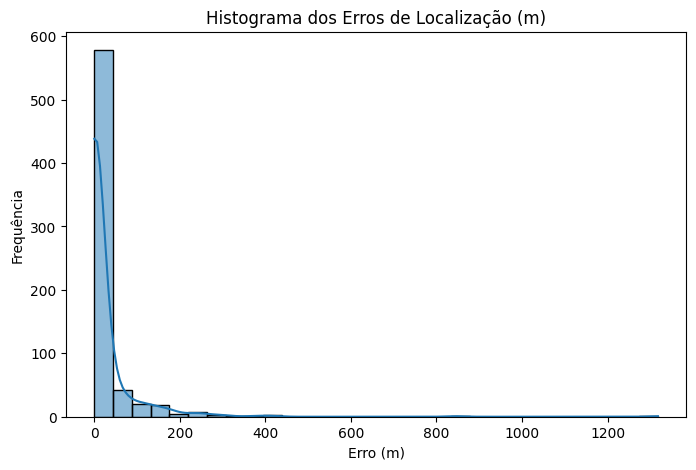

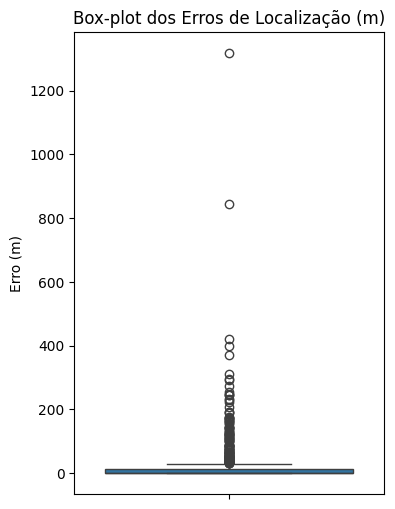

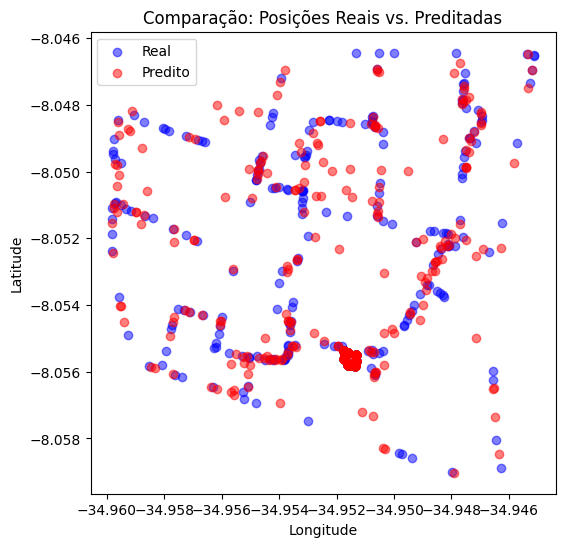

In [5]:
# --------------------------------------------------------
# 4.3 - Geração dos gráficos
# --------------------------------------------------------
# Histograma dos erros
plt.figure(figsize=(8, 5))
sns.histplot(valid_df["error_meters"], bins=30, kde=True)
plt.title("Histograma dos Erros de Localização (m)")
plt.xlabel("Erro (m)")
plt.ylabel("Frequência")
plt.show()

# Box-plot dos erros
plt.figure(figsize=(4, 6))
sns.boxplot(y=valid_df["error_meters"])
plt.title("Box-plot dos Erros de Localização (m)")
plt.ylabel("Erro (m)")
plt.show()

# Mapa de comparação: posições preditas vs. posições reais
plt.figure(figsize=(6, 6))
plt.scatter(valid_df["lon"], valid_df["lat"], c="blue", label="Real", alpha=0.5)
plt.scatter(valid_df["lon_pred"], valid_df["lat_pred"], c="red", label="Predito", alpha=0.5)
plt.title("Comparação: Posições Reais vs. Preditadas")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()  

#### Gerando output dos resultados

In [6]:
# --------------------------------------------------------
# 4.4 - Geração do arquivo de resultados para o conjunto de teste
# --------------------------------------------------------
# Aqui, usamos todo o df_train para compor o banco de fingerprints
train_fingerprint_full = df_train.reset_index(drop=True)
preds_test = []
for i, row in df_test.iterrows():
    try:
        test_vector = [row[col] for col in feature_cols]
    except KeyError:
        continue
    lat_pred, lon_pred = fingerprint_prediction(test_vector, train_fingerprint_full, feature_cols, k=k_value)
    sample_id = row.get("ponto_id", f"test_{i}")
    preds_test.append({
        "Id": sample_id,
        "lat_y": lat_pred,
        "lon_y": lon_pred
    })

df_preds_test = pd.DataFrame(preds_test)
df_preds_test.to_csv(output_file, index=False)
print(f"Arquivo de resultados gerado: {output_file}")

Arquivo de resultados gerado: Resultados_Equipe1_Fingerprint.csv


### Usando base extendida (GAN)

Erro médio: 28.60 m
Erro mínimo: 0.00 m
Erro máximo: 430.70 m
Desvio padrão do erro: 40.84 m


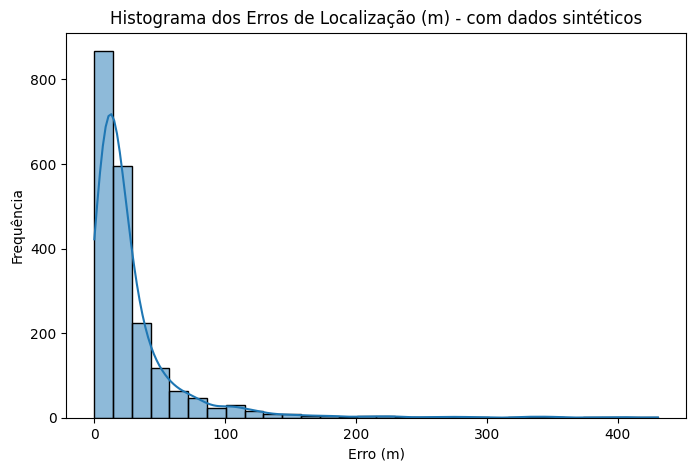

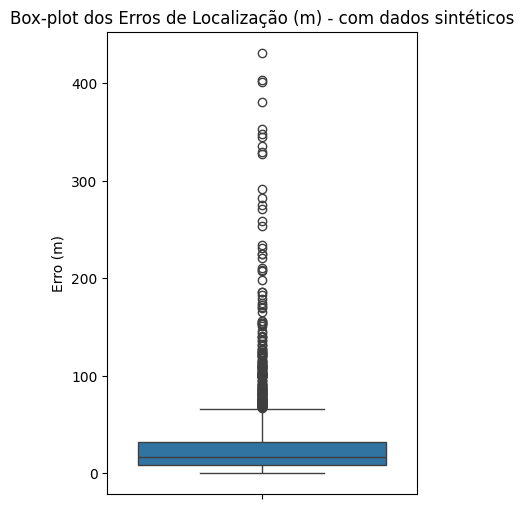

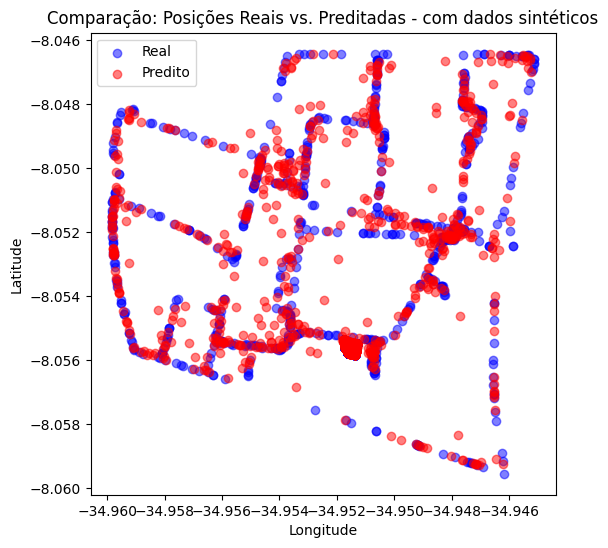

In [10]:
# ------------------------------------------------------------
# 5. Script Principal usando base com dados sintéticos
# ------------------------------------------------------------

training_file = "generated_data_CGAN.csv"
test_file = "meds_test_alunos.csv"
submit_template_file = "submit_alunos.csv"  # Template para resultados
output_file = "Resultados_Equipe1_Fingerprint_com_GAN.csv"

# Leitura dos dados
df_train = pd.read_csv(training_file)
df_test = pd.read_csv(test_file)

# Lista de features usadas para o fingerprinting
feature_cols = [
    "rssi_1_1", "rssi_1_2", "rssi_1_3",
    "rssi_2_1", "rssi_2_2", "rssi_2_3",
    "rssi_3_1", "rssi_3_2", "rssi_3_3",
    "delay_1", "delay_2", "delay_3"
]

# Verifica se as colunas existem no dataframe de treino
missing_cols = [col for col in feature_cols if col not in df_train.columns]
if missing_cols:
    raise ValueError(f"As colunas {missing_cols} não foram encontradas no arquivo de treino.")

# --------------------------------------------------------
# 5.1 - Separar 10% do treino para validação (para gerar os gráficos e métricas)
# --------------------------------------------------------
train_fingerprint, valid_df = train_test_split(df_train, test_size=0.1, random_state=42)
train_fingerprint = train_fingerprint.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

# Valor de k a ser usado (neste exemplo, k=3)
k_value = 3

# Previsões para a base de validação
preds_lat = []
preds_lon = []
for _, row in valid_df.iterrows():
    test_vector = [row[col] for col in feature_cols]
    lat_pred, lon_pred = fingerprint_prediction(test_vector, train_fingerprint, feature_cols, k=k_value)
    preds_lat.append(lat_pred)
    preds_lon.append(lon_pred)

valid_df["lat_pred"] = preds_lat
valid_df["lon_pred"] = preds_lon

# Cálculo do erro em metros usando a fórmula de Haversine
errors = []
for _, row in valid_df.iterrows():
    err = haversine_distance(row["lat"], row["lon"], row["lat_pred"], row["lon_pred"])
    errors.append(err)
valid_df["error_meters"] = errors

# --------------------------------------------------------
# 5.2 - Estatísticas do erro
# --------------------------------------------------------
mean_error = valid_df["error_meters"].mean()
min_error = valid_df["error_meters"].min()
max_error = valid_df["error_meters"].max()
std_error = valid_df["error_meters"].std()

print(f"Erro médio: {mean_error:.2f} m")
print(f"Erro mínimo: {min_error:.2f} m")
print(f"Erro máximo: {max_error:.2f} m")
print(f"Desvio padrão do erro: {std_error:.2f} m")

# --------------------------------------------------------
# 5.3 - Geração dos gráficos
# --------------------------------------------------------
# Histograma dos erros
plt.figure(figsize=(8, 5))
sns.histplot(valid_df["error_meters"], bins=30, kde=True)
plt.title("Histograma dos Erros de Localização (m) - com dados sintéticos")
plt.xlabel("Erro (m)")
plt.ylabel("Frequência")
plt.show()

# Box-plot dos erros
plt.figure(figsize=(4, 6))
sns.boxplot(y=valid_df["error_meters"])
plt.title("Box-plot dos Erros de Localização (m) - com dados sintéticos")
plt.ylabel("Erro (m)")
plt.show()

# Mapa de comparação: posições preditas vs. posições reais
plt.figure(figsize=(6, 6))
plt.scatter(valid_df["lon"], valid_df["lat"], c="blue", label="Real", alpha=0.5)
plt.scatter(valid_df["lon_pred"], valid_df["lat_pred"], c="red", label="Predito", alpha=0.5)
plt.title("Comparação: Posições Reais vs. Preditadas - com dados sintéticos")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()  

In [11]:
# --------------------------------------------------------
# 5.4 - Geração do arquivo de resultados para o conjunto de teste - com dados sintéticos
# --------------------------------------------------------
# Aqui, usamos todo o df_train para compor o banco de fingerprints
train_fingerprint_full = df_train.reset_index(drop=True)
preds_test = []
for i, row in df_test.iterrows():
    try:
        test_vector = [row[col] for col in feature_cols]
    except KeyError:
        continue
    lat_pred, lon_pred = fingerprint_prediction(test_vector, train_fingerprint_full, feature_cols, k=k_value)
    sample_id = row.get("ponto_id", f"test_{i}")
    preds_test.append({
        "Id": sample_id,
        "lat_y": lat_pred,
        "lon_y": lon_pred
    })

df_preds_test = pd.DataFrame(preds_test)
df_preds_test.to_csv(output_file, index=False)
print(f"Arquivo de resultados gerado: {output_file}")

Arquivo de resultados gerado: Resultados_Equipe1_Fingerprint_com_GAN.csv
